# Prepare run

## Import libraries

In [1]:
import os
import re
import glob
import keras
import crested
import anndata
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path
import matplotlib.pyplot as plt
from crested.tl.data import AnnDataModule
from crested.tl import default_configs, TaskConfig

import matplotlib
%matplotlib inline
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

## Setup directories

Download the data for the notebooks from the dedicated Zenodo link of the CREsted paper. Then use it below.

In [ ]:
data_dir = Path("../../../crested_data/Figure_4")
deepccl_dir = Path(f'deepccl/results/contribution_scores')
deepccl_path = data_dir.joinpath(deepccl_dir)

deepglioma_dir = Path(f'deepglioma/results/contribution_scores')
deepglioma_path = data_dir.joinpath(deepglioma_dir)

# Comparison of contribution scores (Figure 4g)

## Load contribution scores and compute correlations between topics / cell line classes

We have already computed the contribution scores for all the cell lines and topics as shown in the CREsted tutorial.

In [16]:
corrs = {}
top_k = '1k'
hypothetical_contrib = False

classes_of_interest = ['a172', 'gm12878', 'hepg2', 'ln229', 'm059j', 'mm001', 'mm029', 'mm099']
topics_of_interest = ['Topic8', 'Topic21', 'Topic25', 'Topic20', 'Topic14', 'Topic18', 'Topic19']

rename_dict = {
    i:j for i, j in zip(['a172', 'gm12878', 'hepg2', 'ln229', 'm059j', 'mm001', 'mm029', 'mm099'], ['A172', 'GM12878', 'HepG2', 'LN229', 'M059J', 'MM001', 'MM029', 'MM099'])
}

Cell lines vs Topics

In [17]:
for class_idx, sel_class in enumerate(classes_of_interest):

    print(f'\nComparing {sel_class}')
    corrs[sel_class] = {}
    oh_cell_contrib = sorted(
        glob.glob(
            f"{str(deepccl_path)}/biopsies_prop_contribution_scores_{top_k}_{sel_class}/*oh*.npz"
        )
    )

    cell_contrib = sorted(
        glob.glob(
            f"{str(deepccl_path)}/biopsies_prop_contribution_scores_{top_k}_{sel_class}/*contrib*.npz"
        )
    )

    oh_topic_contrib = sorted(
        glob.glob(
            f'{str(deepglioma_path)}/atacpred_prop_contribution_scores_{top_k}/*oh*.npz'
        )
    )

    topic_contrib = sorted(
        glob.glob(
            f'{str(deepglioma_path)}/atacpred_prop_contribution_scores_{top_k}/*contrib*.npz'
        )
    )

    for sel_idx in range(0, len(topic_contrib)):
        sel_topic = Path(oh_cell_contrib[sel_idx]).stem.split('_')[0]
        if sel_topic in topics_of_interest:
            topic_idx = topics_of_interest.index(sel_topic)
            print(sel_topic)

            sel_oh_contrib = np.load(oh_cell_contrib[sel_idx])['arr_0']
            sel_contrib = np.load(cell_contrib[sel_idx])['arr_0']

            if 'Topic' in sel_class:
                sel_oh_contrib = np.transpose(sel_oh_contrib, (0, 2, 1))
                sel_contrib = np.transpose(sel_contrib, (0, 2, 1))
            else:
                sel_oh_contrib = sel_oh_contrib[:, :, 807:1307]
                sel_contrib = sel_contrib[:, :, 807:1307]

            sel_oh_topic_contrib = np.load(oh_topic_contrib[sel_idx])['arr_0']
            sel_topic_contrib = np.load(topic_contrib[sel_idx])['arr_0']

            exclude_idx = [x for x in range(sel_oh_contrib.shape[0]) if (sel_oh_contrib == sel_oh_topic_contrib)[x, :, :].sum() != 2000]
            if exclude_idx:
                print('Found mismatched sequences!')

            sel_ohe_contrib = (sel_oh_contrib * sel_contrib)
            sel_ohe_topic_contrib = (sel_oh_topic_contrib * sel_topic_contrib)

            # For hypothetical contribution scores
            if hypothetical_contrib:
                filtered_arr1 = np.delete(sel_contrib, exclude_idx, axis=0)
                filtered_arr2 = np.delete(sel_topic_contrib, exclude_idx, axis=0)
                flat1 = filtered_arr1.reshape(filtered_arr1.shape[0], -1)
                flat2 = filtered_arr2.reshape(filtered_arr2.shape[0], -1)

                correlations = [np.corrcoef(flat1[i], flat2[i])[0, 1] for i in range(flat1.shape[0])]
                agg_correlation = np.median(correlations)
                corrs[sel_class][sel_topic] = agg_correlation
                print("Median Correlation:", agg_correlation)

             # Keep only actual contribution scores (ohe * contrib)
            else:
                filtered_arr1 = np.delete(sel_ohe_contrib, exclude_idx, axis=0)
                filtered_arr2 = np.delete(sel_ohe_topic_contrib, exclude_idx, axis=0)
                max_abs_indices1 = np.argmax(np.abs(filtered_arr1), axis=1)
                max_abs_indices2 = np.argmax(np.abs(filtered_arr2), axis=1)

                rows = np.arange(filtered_arr1.shape[0])[:, None]
                max_vals1 = filtered_arr1[rows, max_abs_indices1, np.arange(500)]
                max_vals2 = filtered_arr2[rows, max_abs_indices2, np.arange(500)]

                correlations = [np.corrcoef(max_vals1[i], max_vals2[i])[0, 1] for i in range(max_vals1.shape[0])]
                agg_correlation = float(np.median(correlations))
                corrs[sel_class][sel_topic] = agg_correlation
                print("Median Correlation:", agg_correlation)


Comparing a172
Topic14
Median Correlation: 0.016003491650292148
Topic18
Median Correlation: 0.08862672455306056
Topic19
Median Correlation: -0.08207824691006735
Topic20
Median Correlation: 0.23501058719770646
Topic21
Median Correlation: 0.30332443521430263
Topic25
Median Correlation: 0.3122383767711748
Topic8
Median Correlation: 0.5990437517257812

Comparing gm12878
Topic14
Median Correlation: -0.14370042295509194
Topic18
Median Correlation: -0.07530124802046961
Topic19
Median Correlation: -0.09354584893882484
Topic20
Median Correlation: -0.13205838810792564
Topic21
Median Correlation: -0.0073557516221341695
Topic25
Median Correlation: -0.10856750950893282
Topic8
Median Correlation: -0.013170321928499788

Comparing hepg2
Topic14
Median Correlation: -0.08251860392051336
Topic18
Median Correlation: -0.04294007916134386
Topic19
Median Correlation: -0.01628622083171154
Topic20
Median Correlation: -0.07690555809337185
Topic21
Median Correlation: 0.03197434000962697
Topic25
Median Correlati

Cell lines vs Cell lines

In [18]:
classes_of_interest = ['a172', 'gm12878', 'hepg2', 'ln229', 'm059j', 'mm001', 'mm029', 'mm099']

for class_idx, sel_class in enumerate(classes_of_interest):

    print(f'\nComparing {sel_class}')
    oh_cell_contrib = sorted(
        glob.glob(
            f"{str(deepccl_path)}/atacpred_prop_contribution_scores_{top_k}_{sel_class}/*oh*.npz"
        )
    )

    cell_contrib = sorted(
        glob.glob(
            f"{str(deepccl_path)}/atacpred_prop_contribution_scores_{top_k}_{sel_class}/*contrib*.npz"
        )
    )

    for dars_idx, dars_class in enumerate(classes_of_interest):

        oh_topic_contrib = sorted(
            glob.glob(
                f"{str(deepccl_path)}/atacpred_prop_contribution_scores_{top_k}_{dars_class}/*oh*.npz"
            )
        )

        topic_contrib = sorted(
            glob.glob(
                f"{str(deepccl_path)}/atacpred_prop_contribution_scores_{top_k}_{dars_class}/*contrib*.npz"
            )
        )

        sel_topic = Path(oh_cell_contrib[dars_idx]).stem.split('_')[0]
        if sel_topic != dars_class:
            print('Mismatch in classes during looping!')

        print(sel_topic)
        sel_oh_contrib = np.load(oh_cell_contrib[dars_idx])['arr_0']
        sel_contrib = np.load(cell_contrib[dars_idx])['arr_0']

        sel_oh_topic_contrib = np.load(oh_topic_contrib[dars_idx])['arr_0']
        sel_topic_contrib = np.load(topic_contrib[dars_idx])['arr_0']

        exclude_idx = [x for x in range(sel_oh_contrib.shape[0]) if (sel_oh_contrib == sel_oh_topic_contrib)[x, :, :].sum() != 8456]
        if exclude_idx:
            print('Found mismatched sequences!')

        sel_ohe_contrib = (sel_oh_contrib * sel_contrib)
        sel_ohe_topic_contrib = (sel_oh_topic_contrib * sel_topic_contrib)
    
        # For hypothetical contribution scores
        if hypothetical_contrib:
            filtered_arr1 = np.delete(sel_contrib, exclude_idx, axis=0)
            filtered_arr2 = np.delete(sel_topic_contrib, exclude_idx, axis=0)
            flat1 = filtered_arr1.reshape(filtered_arr1.shape[0], -1)
            flat2 = filtered_arr2.reshape(filtered_arr2.shape[0], -1)

            correlations = [np.corrcoef(flat1[i], flat2[i])[0, 1] for i in range(flat1.shape[0])]
            agg_correlation = np.median(correlations)
            corrs[sel_class][sel_topic] = agg_correlation
            print("Median Correlation:", agg_correlation)

         # Keep only actual contribution scores (ohe * contrib)
        else:
            filtered_arr1 = np.delete(sel_ohe_contrib, exclude_idx, axis=0)
            filtered_arr2 = np.delete(sel_ohe_topic_contrib, exclude_idx, axis=0)
            max_abs_indices1 = np.argmax(np.abs(filtered_arr1), axis=1)
            max_abs_indices2 = np.argmax(np.abs(filtered_arr2), axis=1)

            rows = np.arange(filtered_arr1.shape[0])[:, None]
            max_vals1 = filtered_arr1[rows, max_abs_indices1, np.arange(2114)]
            max_vals2 = filtered_arr2[rows, max_abs_indices2, np.arange(2114)]

            correlations = [np.corrcoef(max_vals1[i], max_vals2[i])[0, 1] for i in range(max_vals1.shape[0])]
            agg_correlation = float(np.median(correlations))
            corrs[sel_class][sel_topic] = agg_correlation
            print("Median Correlation:", agg_correlation)


Comparing a172
a172
Median Correlation: 1.0
gm12878
Median Correlation: -0.17518454127896405
hepg2
Median Correlation: -0.3068725808678782
ln229
Median Correlation: -0.07732709039738966
m059j
Median Correlation: 0.880136657685227
mm001
Median Correlation: -0.4410549662286317
mm029
Median Correlation: 0.7176441549826454
mm099
Median Correlation: 0.7429169299703847

Comparing gm12878
a172
Median Correlation: -0.24599391829670647
gm12878
Median Correlation: 1.0
hepg2
Median Correlation: -0.31859242270194943
ln229
Median Correlation: -0.4217439733490951
m059j
Median Correlation: -0.37559004962285714
mm001
Median Correlation: -0.47160353688666146
mm029
Median Correlation: -0.27155423271655854
mm099
Median Correlation: -0.38794172151838857

Comparing hepg2
a172
Median Correlation: -0.2323920066976315
gm12878
Median Correlation: -0.2556082634471629
hepg2
Median Correlation: 1.0
ln229
Median Correlation: -0.19212153592451756
m059j
Median Correlation: -0.32932635341176897
mm001
Median Correlat

## Correlation heatmap (Figure 4g)

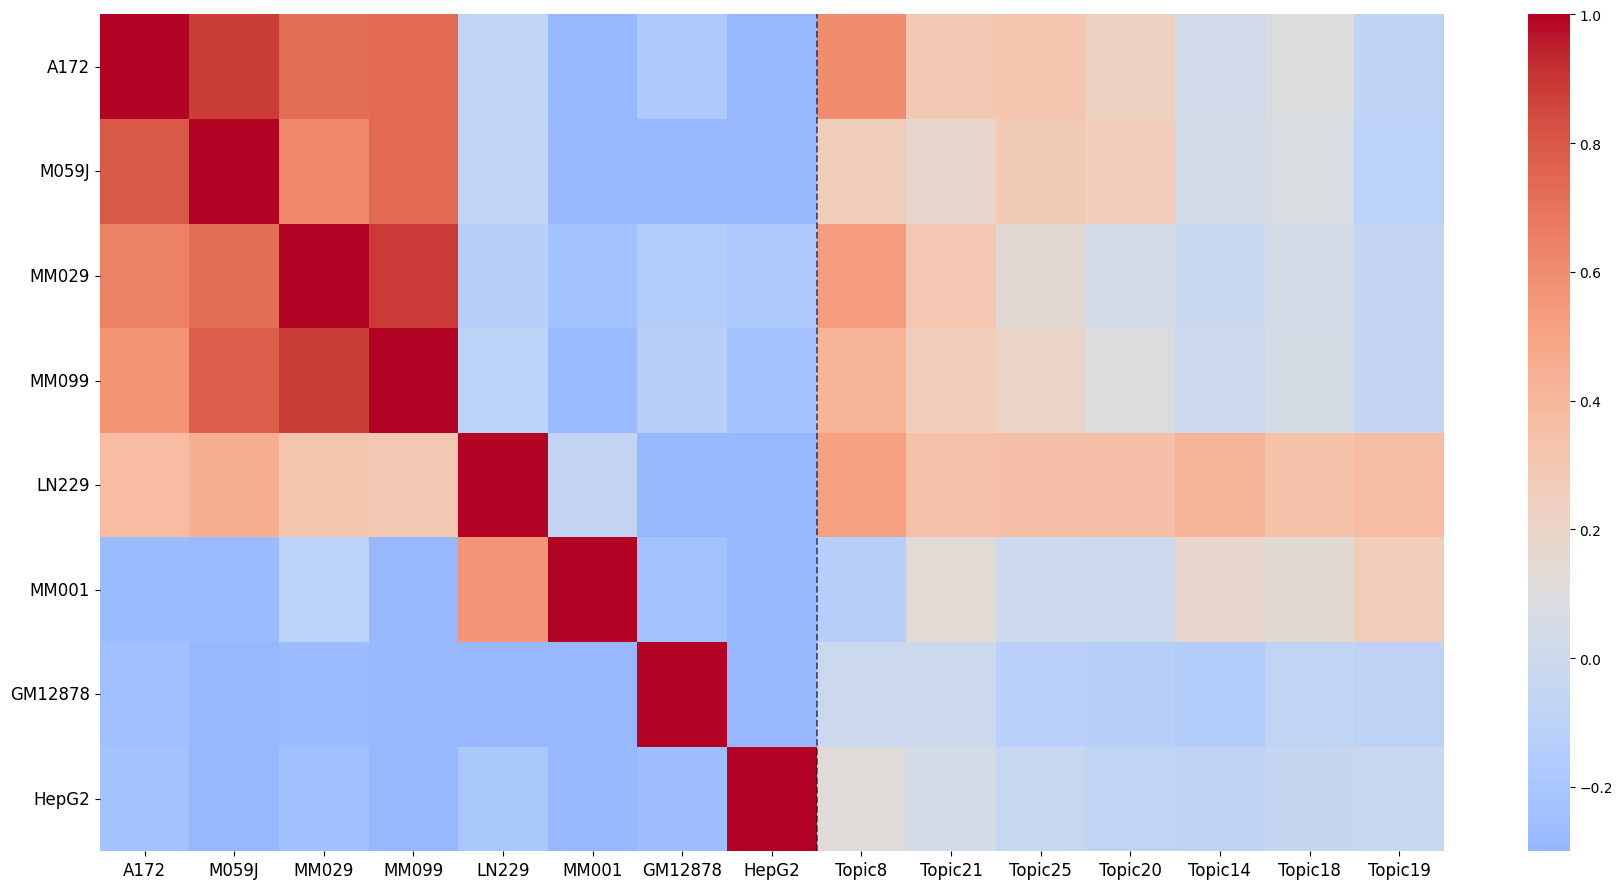

In [19]:
heatmap_df = pd.DataFrame(corrs)
heatmap_df.rename(mapper=rename_dict, axis=1, inplace=True)

plot_df = heatmap_df.T
plot_df.rename(mapper=rename_dict, axis=1, inplace=True)
labels_order = ['A172', 'M059J', 'MM029', 'MM099', 'LN229', 'MM001', 'GM12878', 'HepG2']
topics_order = ['Topic8', 'Topic21', 'Topic25', 'Topic20', 'Topic14', 'Topic18', 'Topic19']
plot_df = plot_df.loc[labels_order, labels_order + topics_order]

plt.figure(figsize=(18, 9))
sns.heatmap(
    plot_df,
    cmap="coolwarm",
    vmin=-0.3,
    center=0.1,
)

plt.axvline(8, color="black", linewidth=1.3, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()